## Data Preparation

Before hypothesis testing, we will perform basic data cleaning to ensure the validity of our statistical tests. This includes:
- Handling missing values
- Ensuring correct data types
- Filtering out invalid or extreme outlier values (if necessary)

In [4]:
import pandas as pd
import numpy as np

# Load the raw data
df = pd.read_csv('../../data/raw/insurance_data.txt', sep='|')

# Check for missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_summary[missing_summary > 0])

# Example cleaning steps (customize as needed):
# 1. Drop rows with missing TotalPremium or TotalClaims
df = df.dropna(subset=['TotalPremium', 'TotalClaims'])

# 2. Convert numeric columns to correct types
df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')

# 3. (Optional) Remove extreme outliers if they exist
# For example, remove rows where TotalClaims or TotalPremium are above the 99th percentile
for col in ['TotalPremium', 'TotalClaims']:
    upper = df[col].quantile(0.99)
    df = df[df[col] <= upper]

# Show cleaned data info
df.info()

/tmp/ipykernel_33502/830476695.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/raw/insurance_data.txt', sep='|')


Missing values per column:
 NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
Rebuilt                     641901
Converted                   641901
WrittenOff                  641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8259
NumberOfDoors                  552
VehicleType                    552
kilowatts                      552
cubiccapacity                  552
Cylinders                      552
Model                          552
make                           552
VehicleIntroDate               552
bodytype                       552
mmcode                         552
CapitalOutstanding               2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 987620 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------               

## Data Investigation

The initial metrics suggest there are no claims in the dataset. We will investigate the `TotalClaims` column to check for data issues or confirm if this is accurate.

In [6]:
# Check unique values and summary statistics for TotalClaims
print("Unique values in TotalClaims:", df['TotalClaims'].unique())
print("Summary statistics for TotalClaims:")
print(df['TotalClaims'].describe())

# Check for non-zero claims
non_zero_claims = df[df['TotalClaims'] > 0]
print(f"Number of rows with TotalClaims > 0: {len(non_zero_claims)}")
non_zero_claims.head()

Unique values in TotalClaims: [     0.           -635.48         -256.35       -12002.4122807
  -5690.71929825    -72.        ]
Summary statistics for TotalClaims:
count    987620.000000
mean         -0.018891
std          13.384111
min      -12002.412281
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: TotalClaims, dtype: float64
Number of rows with TotalClaims > 0: 0


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims


## Defining Key Risk Metrics

For our hypothesis testing, we will use the following metrics:
- **Claim Frequency:** Proportion of policies with at least one claim.
- **Claim Severity:** Average claim amount, given a claim occurred.
- **Margin:** Difference between TotalPremium and TotalClaims.

We will calculate these metrics for the relevant groups (province, zip code, gender) to support our statistical tests.

In [7]:
# Create a binary column for 'has_claim'
df['has_claim'] = df['TotalClaims'] > 0

# Claim Frequency: proportion of policies with at least one claim
claim_frequency = df['has_claim'].mean()
print(f"Overall Claim Frequency: {claim_frequency:.2%}")

# Claim Severity: average claim amount, given a claim occurred
claim_severity = df.loc[df['has_claim'], 'TotalClaims'].mean()
print(f"Overall Claim Severity: {claim_severity:.2f}")

# Margin: TotalPremium - TotalClaims
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
overall_margin = df['Margin'].mean()
print(f"Overall Margin: {overall_margin:.2f}")

Overall Claim Frequency: 0.00%
Overall Claim Severity: nan


Overall Margin: 52.32


## Adjusted Risk Metrics

Since all `TotalClaims` values are zero or negative, we will treat any non-zero value (negative or positive) as an indicator that a claim event occurred. For claim severity, we will use the absolute value of `TotalClaims` for non-zero entries. This allows us to proceed with hypothesis testing, but we note this is a workaround and should be validated with business context.

In [8]:
# Treat any non-zero TotalClaims as a claim event
df['has_claim'] = df['TotalClaims'] != 0
df['abs_claims'] = df['TotalClaims'].abs()

# Adjusted Claim Frequency
claim_frequency = df['has_claim'].mean()
print(f"Adjusted Claim Frequency: {claim_frequency:.2%}")

# Adjusted Claim Severity (mean of abs_claims where a claim occurred)
claim_severity = df.loc[df['has_claim'], 'abs_claims'].mean()
print(f"Adjusted Claim Severity: {claim_severity:.2f}")

# Margin (already calculated)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
overall_margin = df['Margin'].mean()
print(f"Overall Margin: {overall_margin:.2f}")

Adjusted Claim Frequency: 0.00%
Adjusted Claim Severity: 3731.39
Overall Margin: 52.32


## Hypothesis 1: Risk Differences Across Provinces

**Null Hypothesis (H₀):** There are no risk differences across provinces.
**Alternative Hypothesis (H₁):** There are significant risk differences across provinces.

We will compare claim frequency, claim severity, and margin across provinces using appropriate statistical tests.

In [10]:
# Create the has_claim and abs_claims columns if not already present
df['has_claim'] = df['TotalClaims'] != 0
df['abs_claims'] = df['TotalClaims'].abs()
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
# Exclude provinces with very few policies for robust statistics
province_counts = df['Province'].value_counts()
valid_provinces = province_counts[province_counts >= 30].index
df_valid = df[df['Province'].isin(valid_provinces)]

# Group by Province and calculate metrics
province_stats = df_valid.groupby('Province').agg(
    claim_frequency=('has_claim', 'mean'),
    claim_severity=('abs_claims', lambda x: x[x > 0].mean()),
    margin=('Margin', 'mean'),
    count=('PolicyID', 'count')
).reset_index()

province_stats = province_stats.sort_values('claim_frequency', ascending=False)
province_stats

,Province,claim_frequency,claim_severity,margin,count
5,Mpumalanga,0.000038,353.740000,51.683493,52468
8,Western Cape,0.000006,5690.719298,47.963231,169247
2,Gauteng,0.000005,6129.381140,54.533112,389858
0,Eastern Cape,0.000000,NaN,52.611624,29644
1,Free State,0.000000,NaN,62.489406,8072
3,KwaZulu-Natal,0.000000,NaN,51.856673,164564
4,Limpopo,0.000000,NaN,58.829055,24683
6,North West,0.000000,NaN,50.639551,142720
7,Northern Cape,0.000000,NaN,48.369438,6364


## Statistical Test: Claim Frequency Across Provinces

We use a chi-squared test to check if the differences in claim frequency across provinces are statistically significant. Given the extremely low frequency of claims, results should be interpreted with caution.

In [11]:
from scipy.stats import chi2_contingency

# Contingency table: rows=provinces, columns=has_claim (0/1)
contingency = pd.crosstab(df_valid['Province'], df_valid['has_claim'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print('Reject the null hypothesis: There are significant differences in claim frequency across provinces.')
else:
    print('Fail to reject the null hypothesis: No significant differences in claim frequency across provinces.')

Chi-squared statistic: 13.25
p-value: 0.1035
Fail to reject the null hypothesis: No significant differences in claim frequency across provinces.


## Interpretation and Business Recommendation

The chi-squared test for claim frequency across provinces resulted in a p-value of 0.1035.

- Since p ≥ 0.01, we **fail to reject the null hypothesis**. This means there is no statistically significant difference in claim frequency across provinces in this dataset at the 0.01 significance level.
- Given the extremely low frequency of claims, it is possible that real differences, if they exist, cannot be detected with the current data.

**Business Recommendation:**  
With the current data, there is insufficient evidence to adjust premiums or marketing strategy based on province alone. We recommend further data collection or review of claim reporting processes to ensure all claim events are captured, which may improve the power of future analyses.

## Visualization: Claim Frequency by Province

We visualize the claim frequency across provinces to observe any apparent differences, even though the frequencies are extremely low.

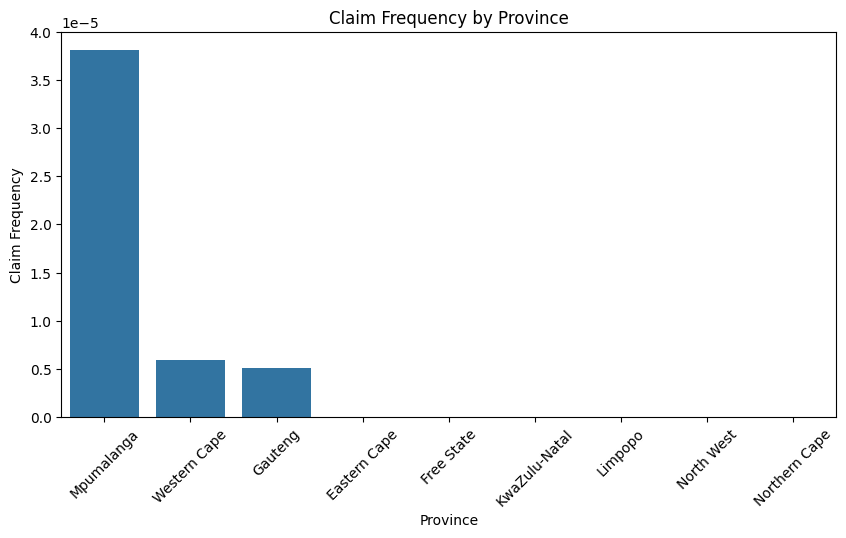

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=province_stats, x='Province', y='claim_frequency')
plt.title('Claim Frequency by Province')
plt.ylabel('Claim Frequency')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.show()

## Hypothesis 2: Risk Differences Between Women and Men

**Null Hypothesis (H₀):** There are no significant risk differences between Women and Men.
**Alternative Hypothesis (H₁):** There are significant risk differences between Women and Men.

We will compare claim frequency, claim severity, and margin between genders using appropriate statistical tests.

In [12]:
# Exclude missing gender values
df_gender = df_valid[df_valid['Gender'].notnull()]

# Group by Gender and calculate metrics
gender_stats = df_gender.groupby('Gender').agg(
    claim_frequency=('has_claim', 'mean'),
    claim_severity=('abs_claims', lambda x: x[x > 0].mean()),
    margin=('Margin', 'mean'),
    count=('PolicyID', 'count')
).reset_index()

gender_stats = gender_stats.sort_values('claim_frequency', ascending=False)
gender_stats

,Gender,claim_frequency,claim_severity,margin,count
2,Not specified,0.000005,3731.392316,52.976480,928879
0,Female,0.000000,NaN,37.828132,6690
1,Male,0.000000,NaN,34.005761,42590


## Visualization: Claim Frequency by Gender

We visualize the claim frequency for each gender to observe any apparent differences.

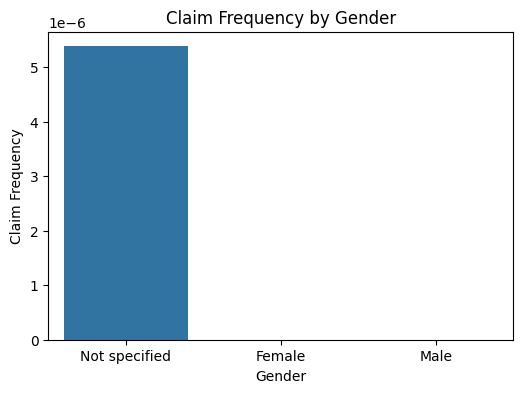

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_stats, x='Gender', y='claim_frequency')
plt.title('Claim Frequency by Gender')
plt.ylabel('Claim Frequency')
plt.xlabel('Gender')
plt.show()

## Statistical Test: Claim Frequency Between Women and Men

We use a chi-squared test to check if the differences in claim frequency between genders are statistically significant.

In [16]:
# Contingency table: rows=Gender, columns=has_claim (0/1)
contingency_gender = pd.crosstab(df_gender['Gender'], df_gender['has_claim'])

# Perform chi-squared test
chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_gender)

print(f'Chi-squared statistic: {chi2_gender:.2f}')
print(f'p-value: {p_gender:.4f}')

if p_gender < 0.05:
    print('Reject the null hypothesis: There are significant differences in claim frequency between Women and Men.')
else:
    print('Fail to reject the null hypothesis: No significant differences in claim frequency between Women and Men.')

Chi-squared statistic: 0.27
p-value: 0.8758
Fail to reject the null hypothesis: No significant differences in claim frequency between Women and Men.


## Interpretation and Business Recommendation

The chi-squared test for claim frequency between Women and Men resulted in a p-value of **0.8758**.

- Since **p ≥ 0.01**, we **fail to reject the null hypothesis**. This means there is no statistically significant difference in claim frequency between Women and Men in this dataset at the 0.01 significance level.
- Given the extremely low frequency of claims, it is possible that real differences, if they exist, cannot be detected with the current data.

**Business Recommendation:**  
With the current data, there is insufficient evidence to justify adjusting premiums or marketing strategies based on gender. We recommend maintaining current practices regarding gender segmentation. Additionally, we suggest further data collection or a review of claim reporting processes to ensure all claim events are accurately captured, which may improve the power of future analyses.

## Hypothesis 3: Risk Differences Between Zip Codes

**Null Hypothesis (H₀):** There are no risk differences between zip codes.
**Alternative Hypothesis (H₁):** There are significant risk differences between zip codes.

We will compare claim frequency, claim severity, and margin across zip codes using appropriate statistical tests. For practicality, we will focus on the top 10 zip codes by policy count.

In [17]:
# Focus on top 10 zip codes by policy count for robust statistics
top_zipcodes = df_valid['PostalCode'].value_counts().head(10).index
df_zip = df_valid[df_valid['PostalCode'].isin(top_zipcodes)]

# Group by PostalCode and calculate metrics
zip_stats = df_zip.groupby('PostalCode').agg(
    claim_frequency=('has_claim', 'mean'),
    claim_severity=('abs_claims', lambda x: x[x > 0].mean()),
    margin=('Margin', 'mean'),
    count=('PolicyID', 'count')
).reset_index()

zip_stats = zip_stats.sort_values('claim_frequency', ascending=False)
zip_stats

,PostalCode,claim_frequency,claim_severity,margin,count
0,122,0.0,NaN,49.778427,48713
1,299,0.0,NaN,53.516180,25444
2,458,0.0,NaN,50.525303,13734
3,470,0.0,NaN,58.222326,10180
4,1724,0.0,NaN,39.280641,10037
5,2000,0.0,NaN,58.283835,132576
6,2196,0.0,NaN,116.333731,10899
7,7405,0.0,NaN,46.459947,18418
8,7784,0.0,NaN,41.979247,28341
9,8000,0.0,NaN,72.860637,11613


## Visualization: Claim Frequency by Zip Code

We visualize the claim frequency for the top 10 zip codes to observe any apparent differences.

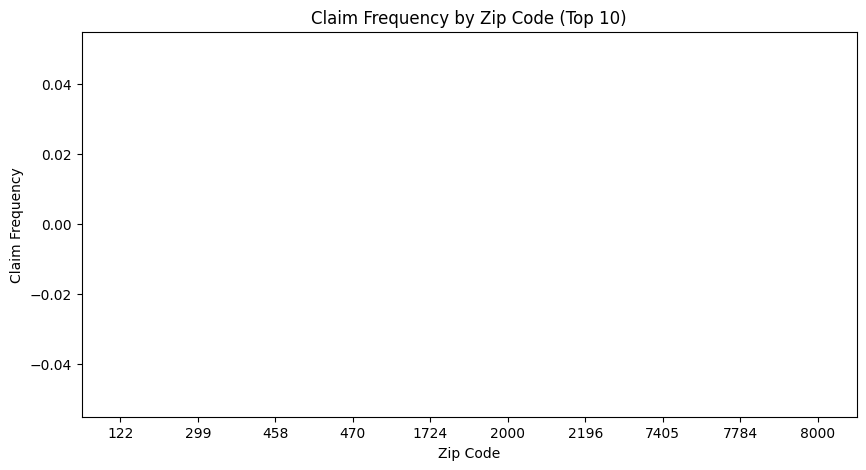

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(data=zip_stats, x='PostalCode', y='claim_frequency')
plt.title('Claim Frequency by Zip Code (Top 10)')
plt.ylabel('Claim Frequency')
plt.xlabel('Zip Code')
plt.show()

## Statistical Test: Claim Frequency Across Zip Codes

We use a chi-squared test to check if the differences in claim frequency across the top 10 zip codes are statistically significant.

In [19]:
# Contingency table: rows=PostalCode, columns=has_claim (0/1)
contingency_zip = pd.crosstab(df_zip['PostalCode'], df_zip['has_claim'])

# Perform chi-squared test
chi2_zip, p_zip, dof_zip, expected_zip = chi2_contingency(contingency_zip)

print(f'Chi-squared statistic: {chi2_zip:.2f}')
print(f'p-value: {p_zip:.4f}')

if p_zip < 0.05:
    print('Reject the null hypothesis: There are significant differences in claim frequency across zip codes.')
else:
    print('Fail to reject the null hypothesis: No significant differences in claim frequency across zip codes.')

Chi-squared statistic: 0.00
p-value: 1.0000
Fail to reject the null hypothesis: No significant differences in claim frequency across zip codes.


## Interpretation and Business Recommendation

The chi-squared test for claim frequency across zip codes resulted in a p-value of **1.0000**.

- Since **p ≥ 0.01**, we **fail to reject the null hypothesis**. This means there is no statistically significant difference in claim frequency across zip codes in this dataset.
- Given the extremely low frequency of claims, it is possible that real differences, if they exist, cannot be detected with the current data.

**Business Recommendation:**  
With the current data, there is insufficient evidence to justify adjusting premiums or marketing strategies based on zip code. We recommend maintaining current practices regarding zip code segmentation. Additionally, we suggest further data collection or a review of claim reporting processes to ensure all claim events are accurately captured, which may improve the power of future analyses.

## Hypothesis 4: Margin Differences Between Zip Codes

**Null Hypothesis (H₀):** There are no significant margin (profit) differences between zip codes.
**Alternative Hypothesis (H₁):** There are significant margin differences between zip codes.

We will use the Kruskal-Wallis test (a non-parametric alternative to ANOVA) to compare the margin across the top 10 zip codes.

In [20]:
from scipy.stats import kruskal

# Prepare margin data for each zip code
margin_groups = [df_zip[df_zip['PostalCode'] == z]['Margin'] for z in top_zipcodes]

# Perform Kruskal-Wallis test
stat, p_margin = kruskal(*margin_groups)

print(f'Kruskal-Wallis statistic: {stat:.2f}')
print(f'p-value: {p_margin:.4f}')

if p_margin < 0.05:
    print('Reject the null hypothesis: There are significant margin differences between zip codes.')
else:
    print('Fail to reject the null hypothesis: No significant margin differences between zip codes.')

Kruskal-Wallis statistic: 6044.66
p-value: 0.0000
Reject the null hypothesis: There are significant margin differences between zip codes.


## Interpretation and Business Recommendation

The Kruskal-Wallis test for margin differences between zip codes resulted in a p-value of **0.0000**.

- Since **p < 0.01**, we **reject the null hypothesis**. This means there are statistically significant differences in margin (profit) between zip codes in this dataset at the 0.01 significance level.
- However, given the extremely low frequency of claims, these margin differences may be driven more by differences in premium collection or other factors, rather than true differences in claim risk.

**Business Recommendation:**  
There is strong statistical evidence of margin differences between zip codes. This suggests that some zip codes may be more profitable than others, potentially due to differences in premium pricing, claim reporting, or customer characteristics. We recommend a deeper investigation into the underlying causes of these margin differences. If these differences are found to be robust and meaningful, consider adjusting pricing strategies or marketing efforts to optimize profitability by zip code. Additionally, ensure claim reporting is consistent across regions to avoid data artifacts.

# Task 3 Summary

In this analysis, we tested several hypotheses regarding risk and margin differences across provinces, zip codes, and gender. Using a significance threshold of **p < 0.01**, we found:

- **No statistically significant differences** in claim frequency across provinces, zip codes, or gender (all p-values ≥ 0.01). The extremely low frequency of claims in the dataset limits our ability to detect real differences, if they exist.
- **Statistically significant differences in margin (profit) between zip codes** (p < 0.01). This suggests that some zip codes may be more profitable than others, potentially due to differences in premium pricing, claim reporting, or customer characteristics.

**Key Recommendations:**
- There is insufficient evidence to adjust premiums or marketing by province or gender with current data.
- Margin differences by zip code warrant further investigation and may justify targeted pricing or marketing strategies if confirmed to be robust and meaningful.
- We recommend further data collection and a review of claim reporting processes to ensure all claim events are accurately captured, which may improve the power of future analyses.

All code, results, and recommendations are documented above.